# Deep Image Prior (DIP) for PAM
## Tri Vu - Updated 051620

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from keras.optimizers import Adam
import os

Using TensorFlow backend.


In [2]:
import sys
print(sys.version)
print(keras.__version__)

3.6.1 (v3.6.1:69c0db5, Mar 21 2017, 18:41:36) [MSC v.1900 64 bit (AMD64)]
2.2.5


In [3]:
""" Choose which gpu to run the training """
gpu = 0  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Step 1: Mode Selection

In [4]:
REG_TRAINING = True # Train the model regularly on a single image

NOISE_REG_EXAM = False  # Examine which noise regularization works best
BATCH_MODE = False  # 

SAVE_MODEL = True  # Save trained model and input noise
SAVE_LOSS = True
SAVE_OUTPUT = True  # Save auxillary info (training time and noise reg) output image, 
                    # with corrected image in the 2nd channel

### Step 2: Params Input and Pre-processing

(1000, 1000, 3)
uint8
uint8


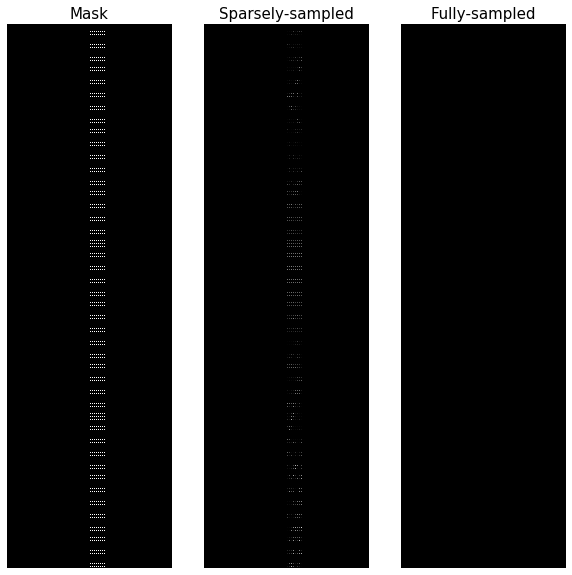

In [5]:
imgpath = './Data/'
imgname = 'brain_xiaoyi_12_6'
outpostname = ''
imgsuffix = 'png'
if REG_TRAINING:
    im = cv2.imread(imgpath + imgname + '.' + imgsuffix)
#     im = im[round(im.shape[0]/2)-150:round(im.shape[0]/2)+150, round(im.shape[1]/2)-150:round(im.shape[1]/2)+150, :]
#     im = im[150:450, 350:650, :]  # For '20190423_thinnedskull_Epi_   2_Image1_index0_pad_3-7' 
#     # For 'reslt_OR_2 (28)_index0_1-12_1-6'
#     im = im[round(im.shape[0]/2)-190:round(im.shape[0]/2)+110, round(im.shape[1]/2)-100:round(im.shape[1]/2)+200, :]  
#     # For 'poly_img__index1_combined'
#     im = im[round(im.shape[0]/2)-300:round(im.shape[0]/2)+900, round(im.shape[1]/2)-1500:round(im.shape[1]/2)-300, :]  
    # For 'brain_xiaoyi_12_6'
    im = im[round(im.shape[0]/2)-500:round(im.shape[0]/2)+500, round(im.shape[1]/2)-500:round(im.shape[1]/2)+500, :]
    print(im.shape)
    im, im_gt, im_masked, im_mask, im_down, factor, _, _ = readImg(im)
    
    print(im.dtype)
    print(im_gt.dtype)

    constructPlot(im, 
                  ['', 'Mask', 'Sparsely-sampled', 'Fully-sampled'], 
                  fsize=(10,10))
    
#     plt.imshow(im_down)
#     plt.show()

#     plt.imshow(im_masked)
#     plt.show()

In [6]:
if BATCH_MODE:
    imgpath = './Data/10_5'
    batch_range = [1, 30]

In [7]:
if NOISE_REG_EXAM:
    imgpath = './Data/4_1/'
    imgname = ['532_OR_39_index0_1-12_1-4', 'reslt_OR_2 (28)_index0_1-12_1-4', 'reslt_OR_7 (4)_index0_1-12_1-4']
    imgsuffix = 'png'
    noise_range = [0.01, 0.21]
#     noise_reg = np.linspace(noise_range[0], noise_range[1], num=31)
    noise_reg = np.arange(noise_range[0], noise_range[1], step=0.01)

In [8]:
# im.shape

### CNN buildup partially contributed by deep prior implement by Kosugi: https://github.com/satoshi-kosugi/DeepImagePrior/blob/master/denoising.py

0.057475165738485656
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


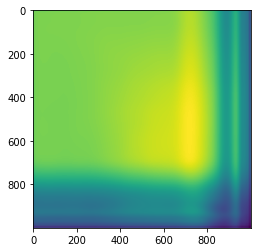

D:\Lab Members\Tree Vu\OneDrive - Duke University\PI Lab\Deep Prior\utils.py:80: RuntimeWarning: invalid value encountered in true_divide
  temp = temp/np.max(temp)*255


0
0.00034484540615132463


KeyboardInterrupt: 

In [9]:
# For regular training 
if REG_TRAINING:
    cur_ssim = ssim(im_down.astype(np.uint8), im_gt)
    print(str(cur_ssim))                                                            
    [sr_image, l, model, 
     totalTrainingTimeHr, 
     input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000, 
             noise_reg=0.07, show_output=True, save_imglog=False, transconvo=False)
    print('Done')

In [ ]:
# print(im_down.shape)

In [ ]:
# For examining noise regularization

if NOISE_REG_EXAM:
    for jj in imgname:
        im = cv2.imread(imgpath + jj + '.' + imgsuffix)
        im = im[round(im.shape[0]/2)-150:round(im.shape[0]/2)+150, round(im.shape[1]/2)-150:round(im.shape[1]/2)+150, :]
        im, im_gt, im_masked, im_mask, im_down, factor, _, _ = readImg(im)
        count = 1
        for ii in noise_reg:
            print('Current noise_reg: ' + str(ii) + '...')
            [sr_image, l, model, totalTrainingTimeHr, input_noise] = train_dp(im_masked, im_gt, im_mask, iter=5000,
                                                                                 noise_reg=ii)
            temp = norm_uint8(sr_image)
            cur_ssim = ssim(temp, im_gt)
            cur_w = model.get_weights()
            if count > 1:
                if cur_ssim > np.max(ssim_rec[:, 1]):  # Record the best model and its output
                    best_w = np.copy(cur_w)
                    best_noise = np.copy(input_noise)
                    best_sr_image = np.copy(sr_image)
                    best_l = np.copy(l)
                    best_reg = np.copy(ii)
                    all_l = np.dstack((all_l, l))
                    print('Best model is at noise reg ' + str(best_reg) + ' with SSIM = ', str(np.max(ssim_rec[:, 1])))
            else:
                ssim_rec = np.array([[ii, cur_ssim]])  # Initialize SSIM record matrix
                best_w = np.copy(cur_w)
                best_noise = np.copy(input_noise)
                best_sr_image = np.copy(sr_image)
                best_l = np.copy(l)
                best_reg = np.copy(ii)
                all_l = l
            ssim_rec = np.concatenate((ssim_rec, [[ii, cur_ssim]]), axis=0)
            if ii < noise_reg[-1]:
                K.clear_session()
            count += 1

        model.set_weights(best_w)
        sr_image = np.squeeze(best_sr_image)
        input_noise = best_noise
        l = best_l
        np.savetxt(imgpath + jj + '_noiseRegvsSSIM.txt', np.asarray(ssim_rec))

        print('Best model is at noise reg ' + str(best_reg) + ' with SSIM = ', str(np.max(ssim_rec[:, 1])))

        plt.plot(ssim_rec[:,0], ssim_rec[:,1])
        plt.show()

### Step 3: Post-processing and Save Vars

In [ ]:
sr_image = norm_uint8(sr_image)

In [ ]:
# Assign output to the channels of the output image
im_out = np.dstack((im_mask, sr_image, im_gt))
# im_out = im_out.reshape((im_out.shape[1], im_out.shape[2], im_out.shape[0]))
im_mask.shape

In [ ]:
plt.imshow(norm_uint8(im_down))
plt.colorbar()
plt.show()
plt.imshow(im_out[:, :, 1])
plt.colorbar()
plt.show()
plt.imshow(im_out[:, :, 2])
plt.colorbar()
plt.show()

In [ ]:
np.max(im_down)

In [ ]:
np.max(sr_image)

In [ ]:
cur_ssim = ssim(im_out[:, :, 1], im_gt)
print(str(cur_ssim))
cur_ssim = ssim(norm_uint8(im_down), im_gt)
print(str(cur_ssim))

### Save model and image

In [ ]:
# imgpath = './Data/'
if SAVE_MODEL:
    model.save(imgpath + '/output/' + imgname + outpostname + '.h5')
    inputNoise = np.squeeze(input_noise)
    inputNoise = inputNoise.reshape((inputNoise.shape[0], inputNoise.shape[1]*inputNoise.shape[2]))
    np.savetxt(imgpath + '/output/' + imgname + '_inputNoise' + outpostname + '.txt', np.asarray(np.squeeze(inputNoise)))

In [ ]:
if SAVE_OUTPUT:
    cv2.imwrite(imgpath + '/output/' + imgname + '_dip_out' + outpostname + '.png', im_out)
    np.savetxt(imgpath + '/output/' + imgname + '_Aux' + outpostname + '.txt', np.asarray([totalTrainingTimeHr]))

In [ ]:
if SAVE_LOSS:
    np.savetxt(imgpath + '/output/' + imgname + '_loss' + outpostname + '.txt', np.asarray(l))

In [ ]:
l_arr = np.asarray(l)
plt.plot(l)
plt.yscale('log')
plt.legend(['SSIM', 'mse', 'Sum'])
plt.show()
print(str(np.min(l)))
l_arr.shape

In [ ]:
totalTrainingTimeHr

In [ ]:
factor

### Read corresponded DL image

In [ ]:
dlpath = imgpath + 'deep_learning/'

In [ ]:
im1 = cv2.imread(imgpath + imgname + '.' + imgsuffix)
dlim = cv2.imread(dlpath + imgname + '.' + imgsuffix)
dlim = cv2.resize(dlim, (im1.shape[1], im1.shape[0]))
print(dlim.shape)
axis1_range=[200, 600]
axis2_range=[300, 1400]
dlim = dlim[axis1_range[0]:axis1_range[1], axis2_range[0]:axis2_range[1], :]

In [ ]:
plt.imshow(dlim)
plt.show()

In [ ]:
plt.imshow(im_gt)
plt.show()